In [1]:
from poseidon.io.iara.offline import load_sonar_from_csv, Target, load_processed_data
from poseidon.model_selection import *

import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
csv_path = "../data/iara.csv"
iara_data_root_path = "/home/iara/"
iara_raw = load_sonar_from_csv(csv_path, data_root_path=iara_data_root_path, target_column="Ship Length Class")

Reading dataset metadata from: ../data/iara.csv
Using data root path: /home/iara/
Grouping by target column: 'Ship Length Class'
Dataset structure loaded. Found 4 classes.
  - Class '0': 476 runs
  - Class '1': 400 runs
  - Class '2': 641 runs
  - Class '3': 308 runs


In [4]:
from poseidon.signal.passivesonar import lofar
from poseidon.signal.utils import resample
from pathlib import Path
cache_dir = './data/iara_cache'
Path(cache_dir).mkdir(parents=True, exist_ok=True)

def lofar_fn(x):
    signal = resample(x['signal'], x['fs'], 16000)
    fs = 16000
    # x is a dict with keys 'signal' and 'fs'
    # x['signal'] is the audio signal, x['fs'] is the sampling frequency
    return lofar(signal, fs, n_pts_fft=1024, n_overlap=0,
                  spectrum_bins_left=512)


iara_raw.process_and_cache(fn=lofar_fn, max_workers=8, cache_path=cache_dir)

Starting PARALLEL processing with 8 workers.
Found 1825 files to process. 0 files are already cached.


Processing runs:  82%|███████████████████████████████████████████████████████████████████████████████                  | 1488/1825 [23:14<03:14,  1.74it/s]/home/code/poseidon/signal/passivesonar.py:81: RuntimeWarning: divide by zero encountered in log10
  power = np.log10(power)
Processing runs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1825/1825 [28:50<00:00,  1.05it/s]


--- Caching Summary ---
Successfully processed and saved: 1825 new files.
Skipped (already cached):      0 files.
Failed to process:             0 files.


In [5]:
iara_spectrogram = load_processed_data(cache_dir)

Loading processed data structure from: ./data/iara_cache
Processed dataset structure loaded. Found 4 classes.
  - Class '0': 476 runs
  - Class '1': 400 runs
  - Class '2': 641 runs
  - Class '3': 308 runs


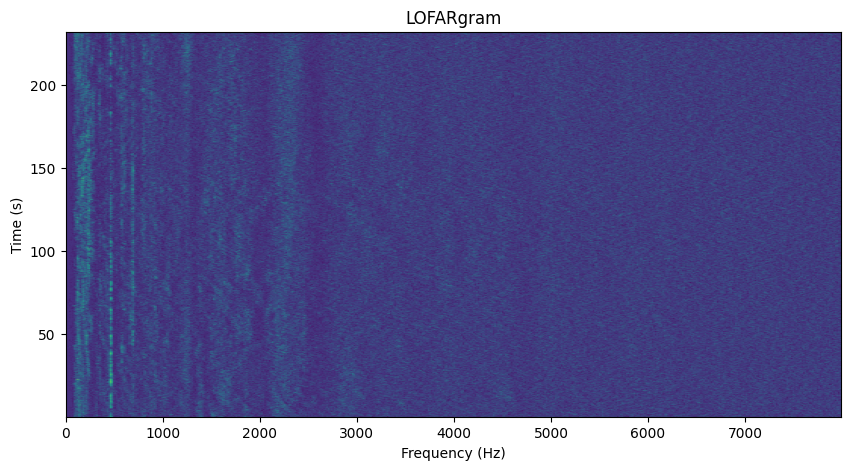

In [13]:
cls = '1'
run = 'A-0003'

sxx =  iara_spectrogram[cls][run]['sxx']
freq = iara_spectrogram[cls][run]['freq']
time = iara_spectrogram[cls][run]['time']

from poseidon.visualization import plot_lofargram
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
plot_lofargram(sxx, freq, time, ax=ax)
plt.show()

In [16]:
from poseidon.model_selection import SonarCrossValidator

metadata_df = pd.read_csv(csv_path)
metadata_df['Length'] = metadata_df['Length'].apply(lambda x: np.nan if x == ' - ' else float(x))
metadata_df['Ship Length Class'] = metadata_df['Length'].apply(Target.classify_value)
metadata_df

cross_validator = SonarCrossValidator(
    metadata_df=metadata_df,
    target_column='Ship Length Class',
    stratify_columns=['Ship Length Class'],
    n_splits=5,
    random_state=42
)

train_data, test_data = cross_validator.get_fold_data(0, cache_dir)

Creating 5 stratified splits based on columns: ['Ship Length Class']
Created class mapping: {0: 0, 1: 1, 2: 2, 3: 3}


In [18]:
from poseidon.dataset import SonarRunDataset, SonarRunPairDataset

dataset = SonarRunDataset(train_data, window_size=16, overlap=15, is2d=True)

Building window map for SonarRunDataset...
Map built. Total windows available: 6286351
